<h3>Time Series Algorithms</h3>

In [165]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math  # for rounding up values
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

df = pd.read_csv('CR_FC_PREP_0522.csv')
df['POD'] = pd.to_datetime(df['POD'])
df.set_index('POD', inplace=True)

df.head()
df.tail()
df.info()
print(f'Dataset size: {df.shape}')

,RATE
POD,
2005-07-19,2200.0
2005-07-20,2250.0
2005-07-21,2300.0
2005-07-22,2280.0
2005-07-23,2260.0


,RATE
POD,
2022-12-27,4121.43
2022-12-28,4142.86
2022-12-29,4164.29
2022-12-30,4185.71
2022-12-31,4207.14


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6375 entries, 2005-07-19 to 2022-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RATE    6375 non-null   float64
dtypes: float64(1)
memory usage: 99.6 KB
Dataset size: (6375, 1)


In [166]:
# After 2023 data to compare accuracy of forecast
df_after = pd.read_csv('CR_FC_PREP_23.csv')
df_after['POD'] = pd.to_datetime(df_after['POD'])

# df_after.set_index('POD',inplace=True)

df_after.head()
df_after.tail()
df_after.info()
print(f'Dataset size: {df_after.shape}')

,POD,RATE
0,2023-01-01,4228.57
1,2023-01-02,4250.00
2,2023-01-03,2800.00
3,2023-01-04,2800.00
4,2023-01-05,2800.00


,POD,RATE
47,2023-02-17,1500.0
48,2023-02-18,1500.0
49,2023-02-19,1500.0
50,2023-02-20,1500.0
51,2023-02-21,1500.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     52 non-null     datetime64[ns]
 1   RATE    52 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 960.0 bytes
Dataset size: (52, 2)


<Axes: xlabel='POD'>

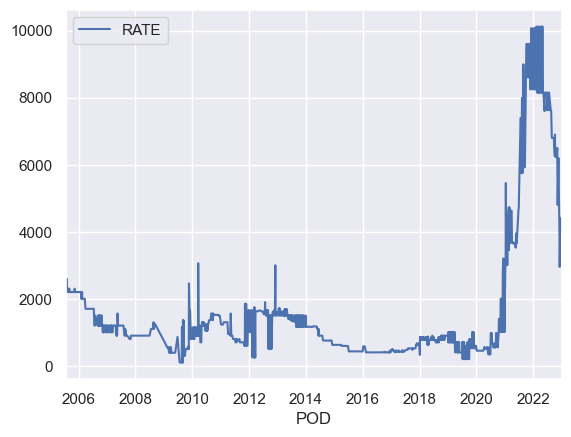

In [167]:
df.plot()

In [168]:
from scipy.stats import skew
skewness = skew(df['RATE'])

# print the skewness value
print("Skewness of RATE column: ", skewness)

# check if the skewness is positive or negative
if skewness > 0:
    print("The RATE column is positively skewed")
elif skewness < 0:
    print("The RATE column is negatively skewed")
else:
    print("The RATE column is symmetric")

Skewness of RATE column:  2.661237498037452
The RATE column is positively skewed


In [169]:
# Check the stationarity of the time series data
result = adfuller(df['RATE'])
print('ADF Statistic: %f' % result[0])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')
print('p-value: %f' % result[1])
if result[1] > 0.05:
    print('The data is non-stationary. Applying first-order differencing.')
    df['diff'] = df['RATE'].diff()
    df = df.dropna()
else:
    print('The data is stationary.')

ADF Statistic: -1.013402
Critical Values:
	1%: -3.4313818532508247
	5%: -2.8619959887727875
	10%: -2.567012719725542
p-value: 0.748345
The data is non-stationary. Applying first-order differencing.


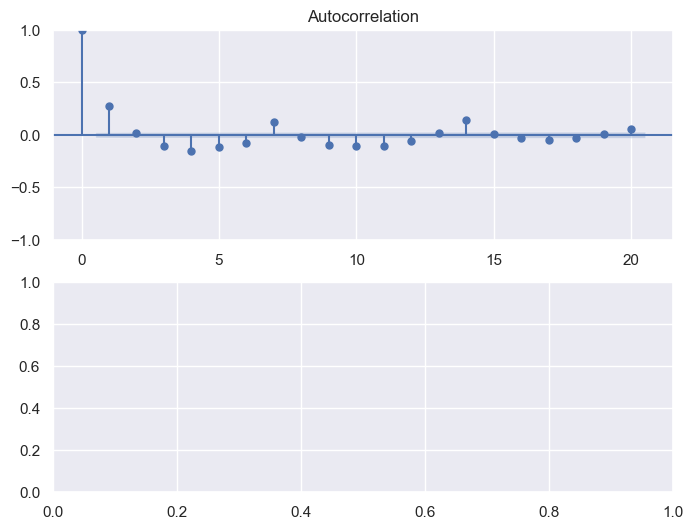

c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


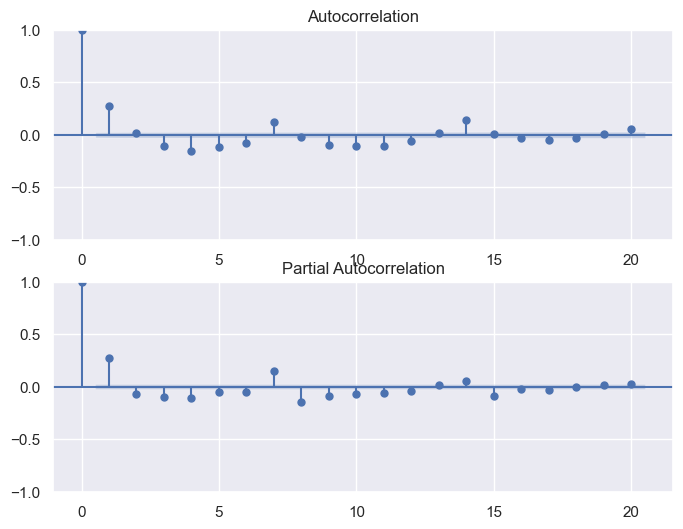

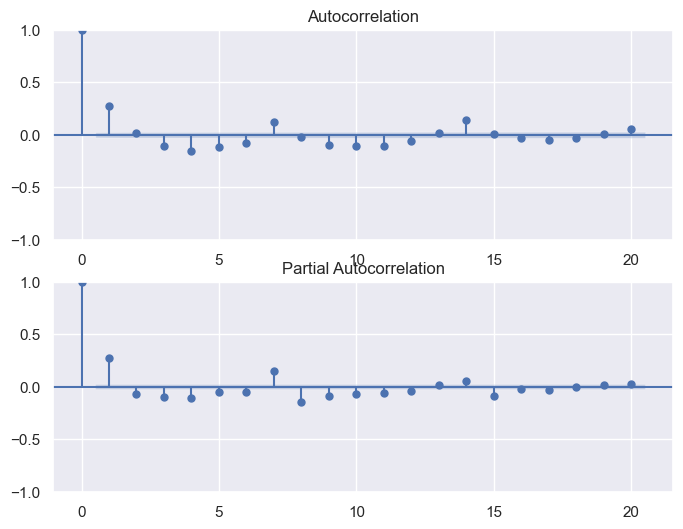

p: 1, d: 1, q: 1


In [170]:

# Step 3: Determine the appropriate ARIMA parameters
# check for stationarity using ADF test
# plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(df['diff'], ax=ax1, lags=20)
plot_pacf(df['diff'], ax=ax2, lags=20)
plt.show()

# Step 4: Determine the values of p, d, and q
p = 1 # number of AR terms (lags) from PACF plot
d = 1 # first-order differencing
q = 1# number of MA terms (lags) from ACF plot

print(f'p: {p}, d: {d}, q: {q}')


In [171]:
# Decompose the time series into its trend, seasonal, and residual components
decomposition = seasonal_decompose(df['RATE'], model='additive', period=365)

<h4>Transformation to target variable</h4>

In [172]:
def applyLogTrans(df):
    # Apply a logarithmic transformation to the rate variable
    return  np.log(df['RATE'])

In [173]:
df['RATE_LOG'] = applyLogTrans(df)
df.head()

C:\Users\it1\AppData\Local\Temp\ipykernel_2916\428569334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RATE_LOG'] = applyLogTrans(df)


,RATE,diff,RATE_LOG
POD,,,
2005-07-20,2250.0,50.0,7.718685
2005-07-21,2300.0,50.0,7.740664
2005-07-22,2280.0,-20.0,7.731931
2005-07-23,2260.0,-20.0,7.723120
2005-07-24,2240.0,-20.0,7.714231


<h4>Start Performing Time Series Algorithm</h4>

In [174]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

def find_AutoARIMA(df):
    # Fit the Auto ARIMA model
    model = pm.auto_arima(df['RATE_LOG'], seasonal=False, suppress_warnings=True, error_action="ignore", stepwise=True, trace=True, test='adf')
    model.summary()

    return model

In [175]:
# Auto Arima
arimaModel = find_AutoARIMA(df)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11630.683, Time=6.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10962.721, Time=0.72 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11041.993, Time=1.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11060.112, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10964.715, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11431.043, Time=5.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11474.664, Time=4.87 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-11458.956, Time=8.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11141.191, Time=3.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-11464.453, Time=9.72 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-11500.551, Time=6.70 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-11557.699, Time=9.25 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-11775.091, Time=3.81 sec
 ARIMA(1,1,2

<h4>Creating new dates after 52 days with 1 empty column</h4>

In [176]:
from datetime import timedelta

# start_date = df.index[-1] + timedelta(days=1)
# print(start_date)
n_periods = 52

def newDateFrame(df, n_periods):
    # Create a data frame for the forecast for the next 24 months
    index_of_fc = pd.date_range(start=df.index[-1], periods = n_periods+1, freq='D')
    newFrameName = pd.DataFrame(index=index_of_fc[1:],columns=df.columns)
    newFrameName.iloc[1:]
    newFrameName.shape

    return newFrameName

In [177]:
arima_df = newDateFrame(df, n_periods)
arima_df.head()
arima_df.tail()
arima_df.info()

,RATE,diff,RATE_LOG
2023-01-01,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN
2023-01-03,NaN,NaN,NaN
2023-01-04,NaN,NaN,NaN
2023-01-05,NaN,NaN,NaN


,RATE,diff,RATE_LOG
2023-02-17,NaN,NaN,NaN
2023-02-18,NaN,NaN,NaN
2023-02-19,NaN,NaN,NaN
2023-02-20,NaN,NaN,NaN
2023-02-21,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2023-01-01 to 2023-02-21
Freq: D
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   RATE      0 non-null      object
 1   diff      0 non-null      object
 2   RATE_LOG  0 non-null      object
dtypes: object(3)
memory usage: 1.6+ KB


<h4>Forecasting values</h4>

In [178]:
# Forecast the future values using ARIMA
forecast_arima_log = arimaModel.predict(n_periods=n_periods)

# Transform the forecasted values back to original scale
forecast_arima = np.exp(forecast_arima_log)

print(forecast_arima)
print(len(forecast_arima))

arima_df['RATE'] = forecast_arima
arima_df['RATE'] = arima_df['RATE'].apply(lambda x: round(x, 2))

# Remove RATE_LOG column to return back to original
arima_df = arima_df.drop('RATE_LOG',axis=1)
arima_df.head()

2023-01-01    4202.081245
2023-01-02    4193.034996
2023-01-03    4188.107670
2023-01-04    4187.453967
2023-01-05    4187.467566
2023-01-06    4193.679195
2023-01-07    4200.407296
2023-01-08    4197.838616
2023-01-09    4191.440566
2023-01-10    4189.832889
2023-01-11    4190.131463
2023-01-12    4190.431212
2023-01-13    4194.076660
2023-01-14    4197.469667
2023-01-15    4195.124985
2023-01-16    4191.345910
2023-01-17    4191.071596
2023-01-18    4191.639178
2023-01-19    4191.850340
2023-01-20    4193.946452
2023-01-21    4195.597793
2023-01-22    4193.782370
2023-01-23    4191.645172
2023-01-24    4191.911292
2023-01-25    4192.415699
2023-01-26    4192.499295
2023-01-27    4193.685542
2023-01-28    4194.458354
2023-01-29    4193.167410
2023-01-30    4192.012452
2023-01-31    4192.428811
2023-02-01    4192.784096
2023-02-02    4192.777638
2023-02-03    4193.445001
2023-02-04    4193.789165
2023-02-05    4192.918559
2023-02-06    4192.326517
2023-02-07    4192.723240
2023-02-08  

,RATE,diff
2023-01-01,4202.08,NaN
2023-01-02,4193.03,NaN
2023-01-03,4188.11,NaN
2023-01-04,4187.45,NaN
2023-01-05,4187.47,NaN


<h4>Measure accuracy comparing with actual cost rate</h4>

In [179]:
from sklearn.metrics import r2_score, mean_absolute_error
def findACC(forecast_df, actual_df):

    # Actual Data
    actual_y = actual_df['RATE']

    # Forecasted Data
    forecast_Y = forecast_df['RATE']

    # Calculate the accuracy of the model using mean absolute error and R-squared
    mae = mean_absolute_error(actual_y, forecast_Y)
    r2 = r2_score(actual_y, forecast_Y)

    print(f"Mean absolute error: {mae:.3f}")
    print(f"R-squared value: {r2:.3f}")

In [180]:
findACC(arima_df, df_after)

Mean absolute error: 1851.360
R-squared value: -5.255


In [185]:
# df_after.set_index('POD', inplace=True)

KeyError: "None of ['POD'] are in the columns"

In [184]:
# # Plot the forecast with current dataset
# plt.figure(figsize=(20, 8))
# plt.plot(df)
# plt.plot(arima_df, color='darkgreen')
# plt.plot(df_after, color='darkred')
# plt.title("Final Forecast of COST_RATE")
# plt.show()